In [1]:
import os
import openai
import io
import uuid
import base64
from base64 import b64decode
import numpy as np
from PIL import Image

from unstructured.partition.pdf import partition_pdf

from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

from operator import itemgetter

In [2]:
in_path = "./ml/input/"
tmp_path = "./ml/temp/"

In [3]:
def doc_partition(in_path,file_name, tmp_path):

  raw_pdf_elements = partition_pdf(
    filename = in_path + file_name,
    image_output_dir_path=tmp_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    )

  return raw_pdf_elements

raw_pdf_elements = doc_partition(in_path,"pet-api.pdf", tmp_path)

raw_pdf_elements = raw_pdf_elements + partition_pdf(
    filename=in_path + "enrollment-api.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=tmp_path,)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def data_category(raw_pdf_elements): # we may use decorator here
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
           tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
           texts.append(str(element))
    data_category = [texts,tables]
    return data_category
texts = data_category(raw_pdf_elements)[0]
tables = data_category(raw_pdf_elements)[1]

In [5]:
def tables_summarize(data_category):
    prompt_text = """You are an assistant tasked with summarizing tables and text. \
                    Give a concise summary of the table or text. Table or text chunk: {element} """

    prompt = ChatPromptTemplate.from_template(prompt_text)
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
    table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})
    #text_summaries =  summarize_chain.batch(data_category[0], {"max_concurrency": 5})# no need to summarize

    return table_summaries
table_summaries = tables_summarize(data_category)
text_summaries = texts

In [6]:
def encode_image(image_path):
    ''' Getting the base64 string '''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def image_captioning(img_base64,prompt):
    ''' Image summary '''
    chat = ChatOpenAI(model="gpt-4-vision-preview",
                      max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text":prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content

In [7]:
import time
# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = "Describe the image in detail. Be specific about graphs, such as bar plots."

# Read images, encode to base64 strings
for img_file in sorted(os.listdir(tmp_path)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(tmp_path, img_file)
        print(img_path)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        #image_summaries.append(image_captioning(base64_image,prompt))
        img_cap = image_captioning(base64_image,prompt)
        #time.sleep(60)
        image_summaries.append(img_cap)


./ml/temp/figure-1-1.jpg
./ml/temp/figure-2-1.jpg
./ml/temp/figure-2-2.jpg
./ml/temp/figure-2-3.jpg
./ml/temp/figure-3-4.jpg
./ml/temp/figure-3-5.jpg
./ml/temp/figure-4-6.jpg
./ml/temp/figure-4-7.jpg
./ml/temp/figure-5-8.jpg
./ml/temp/figure-5-9.jpg
./ml/temp/figure-6-10.jpg
./ml/temp/figure-6-11.jpg
./ml/temp/figure-7-12.jpg


In [8]:
def split_image_text_types(docs):
    ''' Split base64-encoded images and texts '''
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }

In [9]:
# Add raw docs and doc summaries to Multi Vector Retriever.
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [18]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda, RunnableParallel

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
                Include details only for the API referenced in the "Question".
                Question: {dict["question"]}
                Text and tables:
                {format_texts}
                """},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableParallel({"response":prompt_func| model| StrOutputParser(),
                      "context": itemgetter("context"),})
)

In [11]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

To invoke the Pet API, you would follow these steps:

1. Obtain a temporary token by making a call to the security/token API. The details for this step are not provided in the context, but you would refer to the API Integration Guide for the specifics on how to call the Token API.

2. Once you have the token, you can make a call to the functional API. The context provided includes URLs for the MetLife Pet Insurance API in both the test and production environments. Since the question does not specify which environment to use, I'll provide the steps for both:

For the Test Environment:
- Use the following URL to call the Catalog API (Call #1):
  `https://qa.api.metlife.com/metlife/qa/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100`
- This is a GET request, and you will need to include the temporary token obtained from the security/token API in the Authorization header.

For the Production Environment:
- Use the following URL to call the Catalog


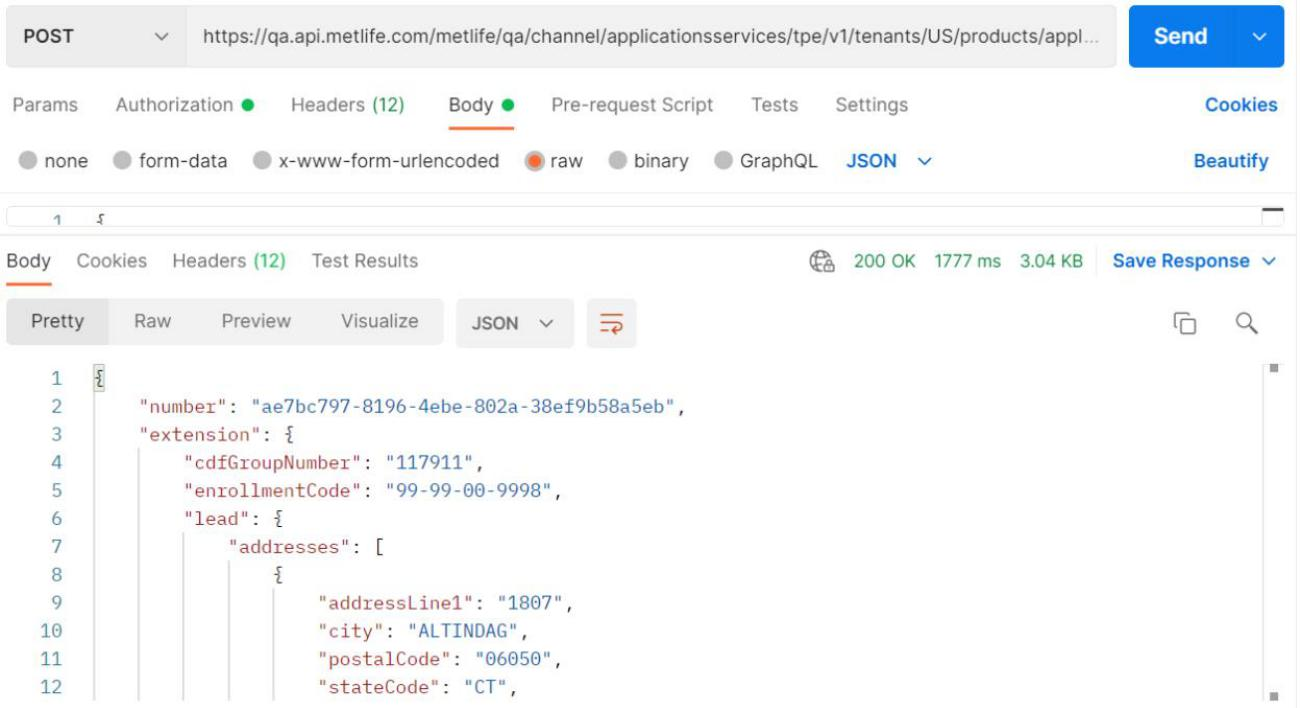

In [23]:
response = chain.invoke(
    "How do I invoke Pet API?"
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

The available functional APIs referenced in the provided context are:

1. Catalog API
   - Test Environment URL: https://qa.api.metlife.com/metlife/qa/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100
   - Production Environment URL: https://api.metlife.com/metlife/production/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100

2. Create Application API (partially visible in the image)
   - Test Environment URL: The full URL is not visible in the image, but it starts with https://qa.api.metlife.com/metlife/qa/channel/applicationsservices/tpe/v1/tenants/US/p...



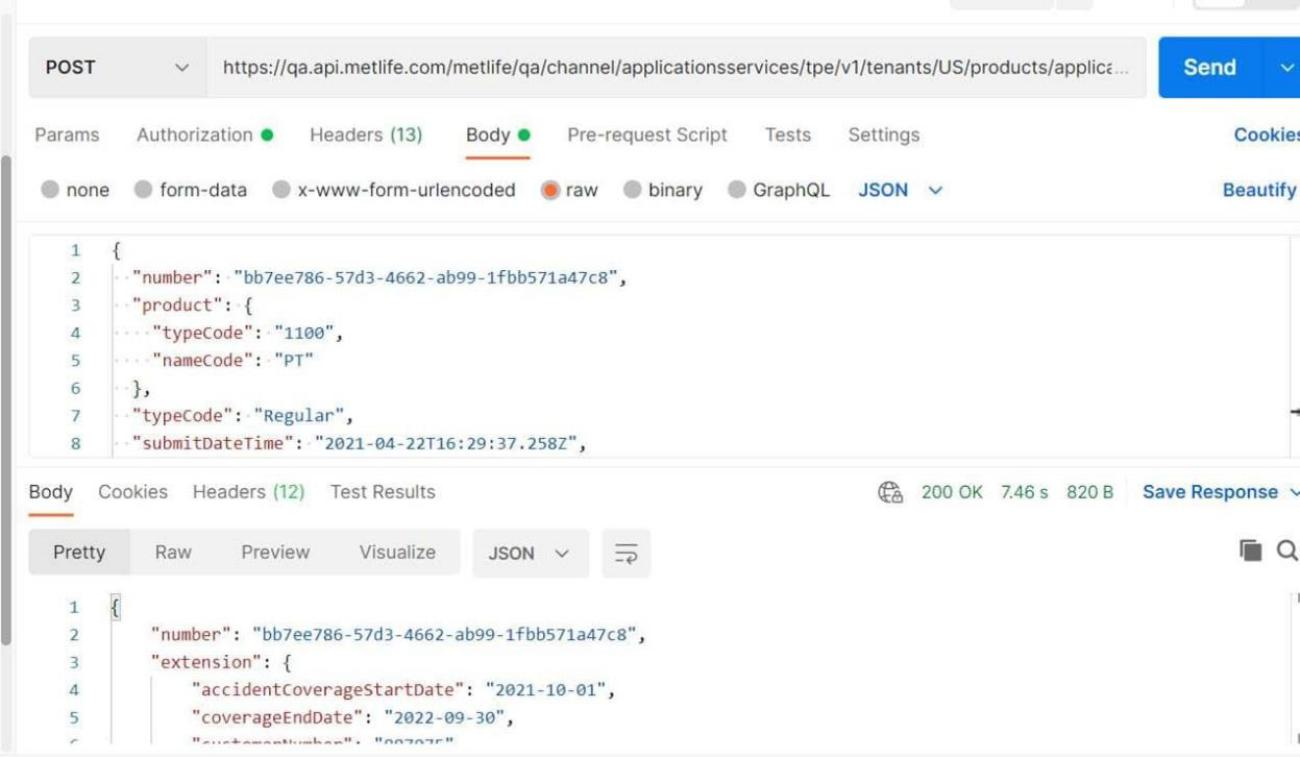

In [22]:
response = chain.invoke(
    "what are the available funtional APIs?"
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

The GET request for the Catalog API in the test environment is as follows:

URL:
```
https://qa.api.metlife.com/metlife/qa/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100
```

Headers:
- `X-gssp-channelId`: TPE
- `x-gssp-trxid`: (A specific transaction ID value, partially obscured in the image)
- `X-IBM-Client-Id`: 3cc0ba0a-22e9-4e1c-9ae8-209ed7132cad

This request is used to retrieve a list of items from the catalog with the type code 1100. The headers likely include authentication and tracking information required by the API.



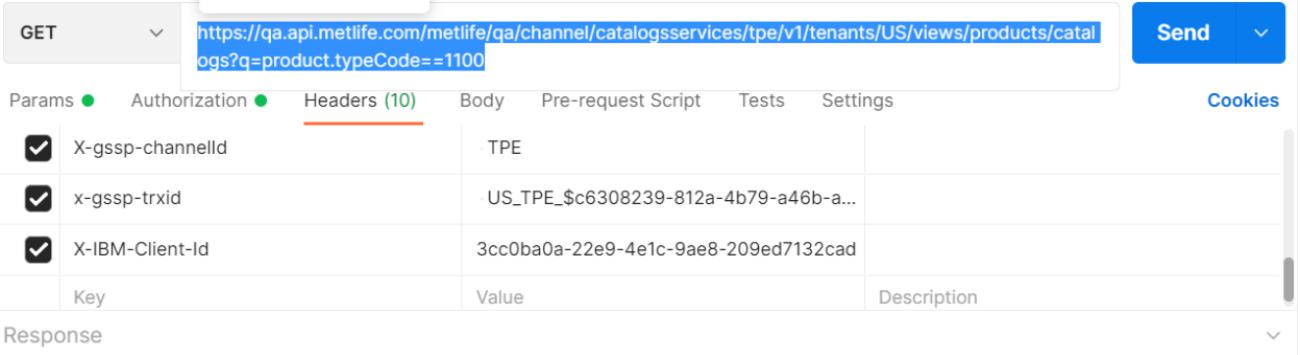

In [21]:
response = chain.invoke(
    "Show me Get request for Catalog API"
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

The test URLs for each Pet API mentioned in the provided context are as follows:

1. Catalog API:
   - Test Environment URL: `https://qa.api.metlife.com/metlife/qa/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100`
   - Production Environment URL: `https://api.metlife.com/metlife/production/channel/catalogsservices/tpe/v1/tenants/US/views/products/catalogs?q=product.typeCode==1100`

2. Create Application API:
   - Test Environment URL: `https://qa.api.metlife.com/metlife/qa/channel/applicationsservices/tpe/v1/tenants/US/products/applications/8fd6e9cf-fbbb-48da-b008-91e009c2d542/submit`
   - Production Environment URL: `https://api.metlife.com/metlife/production/channel/applicationsservices/tpe/v1/tenants/US/products/applications/4b2cbf50-aa28-4ea8-bf36-d03ee63cb0af/submit`

3. Retrieve Leads API:
   - Test Environment URL: `https://qa.api.metlife.com/metlife/qa/channel/leadsservices/tpe/v1/tenants/US/views/products/leads/b708046d-30fd-4784-af41


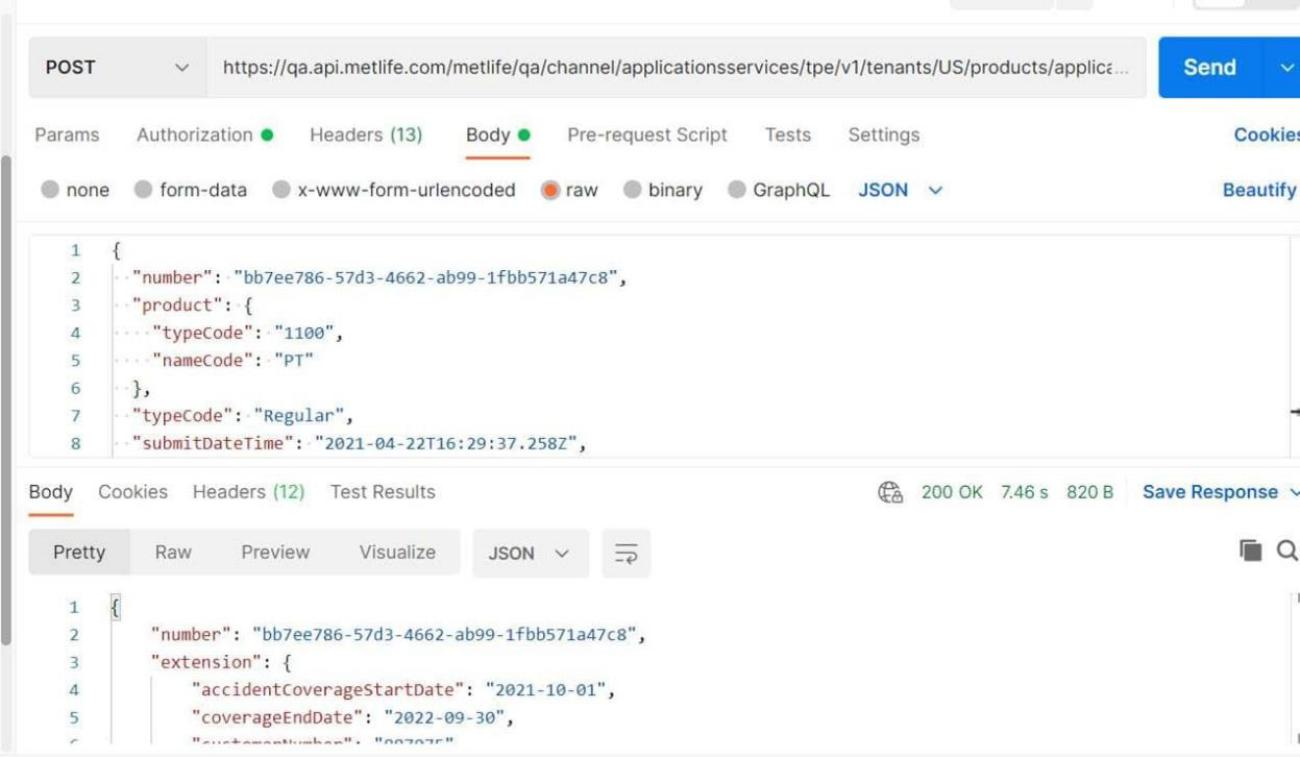

In [20]:
response = chain.invoke(
    "Give me test URLs for each Pet API.",
)
print(response['response'])
plt_img_base64(response['context']['images'][0])

Based on the provided context, a sample POST request for the Enrollment API could look like this:

```
POST /metlife/qa/gwvb/enrollmentServices/api/v1/enrollments HTTP/1.1
Host: qa.api.metlife.com
Content-Type: multipart/form-data; boundary=----WebKitFormBoundary7MA4YWxkTrZu0gW

------WebKitFormBoundary7MA4YWxkTrZu0gW
Content-Disposition: form-data; name="enrollmentMetadata"

{"exampleKey": "exampleValue"}
------WebKitFormBoundary7MA4YWxkTrZu0gW
Content-Disposition: form-data; name="enrollmentPayload"

<PayloadXMLContentHere>
------WebKitFormBoundary7MA4YWxkTrZu0gW--
```

In this request:
- Replace `<Metadata in JSON format>` with actual JSON metadata.
- Replace `<Payload as LDExBEM XML>` with the actual XML payload content.
- The `boundary` in the `Content-Type` header is a placeholder and should be replaced with the actual boundary used to separate parts of the form-data in the request body.



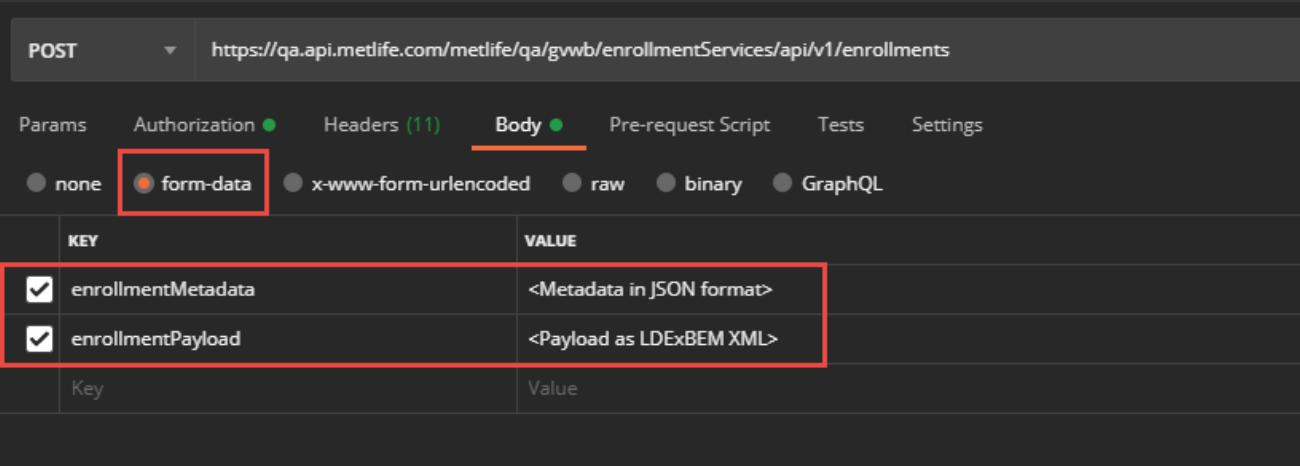


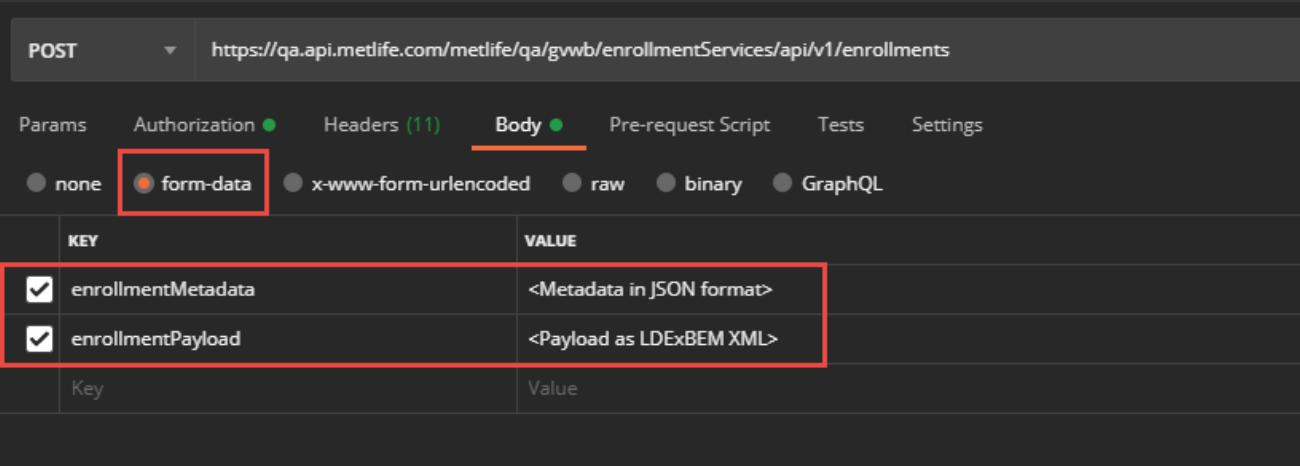


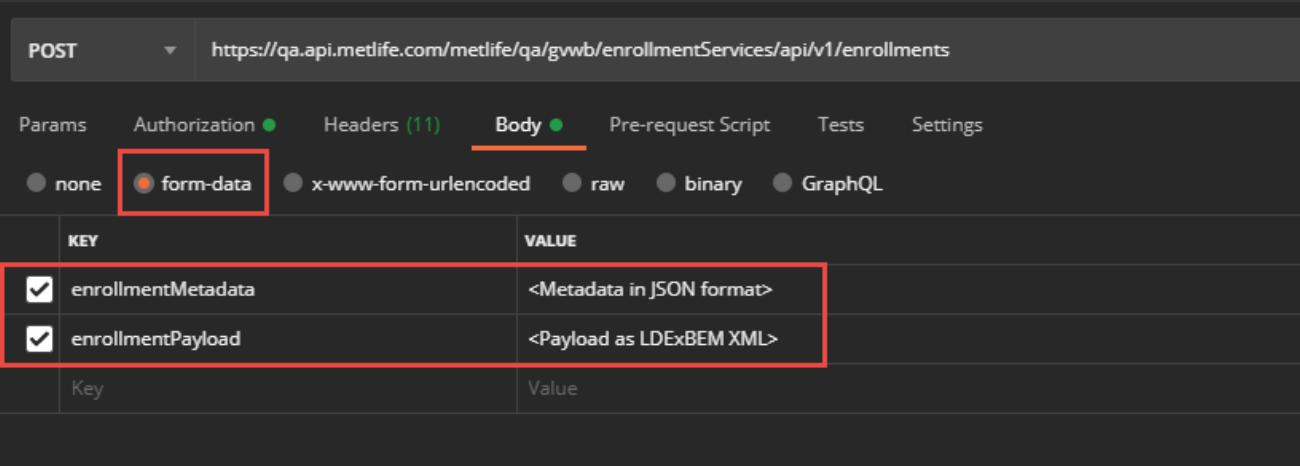


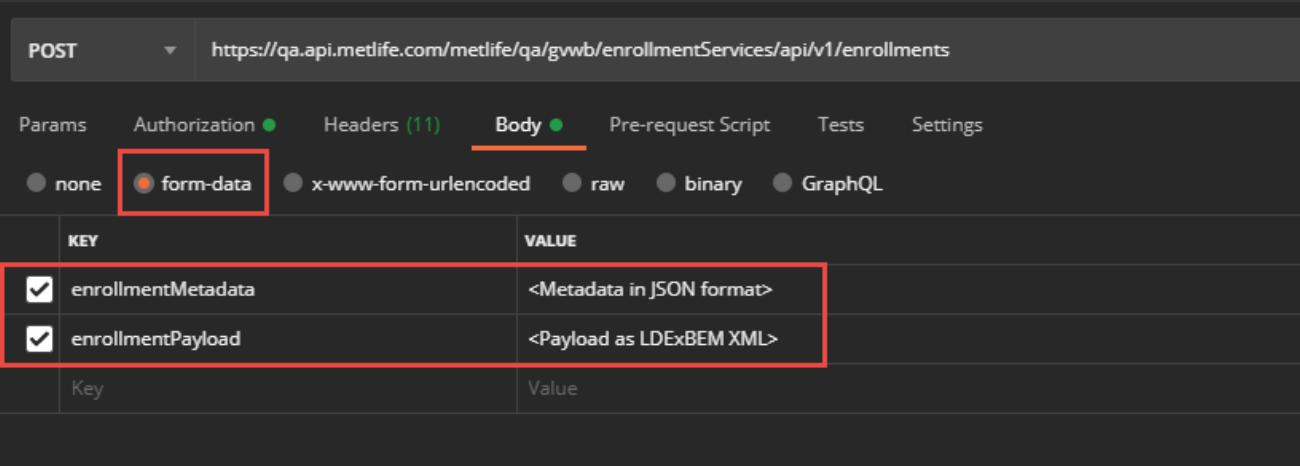

In [16]:
response = chain.invoke("Give me a sample POST request for Enrollment API")
print(response["response"])
for image in response['context']['images']:
    plt_img_base64(response['context']['images'][0])

The list of all Enrollment API URLs mentioned in the provided context is as follows:

1. Test Environment URL:
   - https://qa.api.metlife.com/metlife/qa/gvwb/enrollmentServices/api/v1/enrollments

2. Production Environment URL:
   - https://api.metlife.com/metlife/production/gvwb/enrollmentServices/api/v1/enrollments



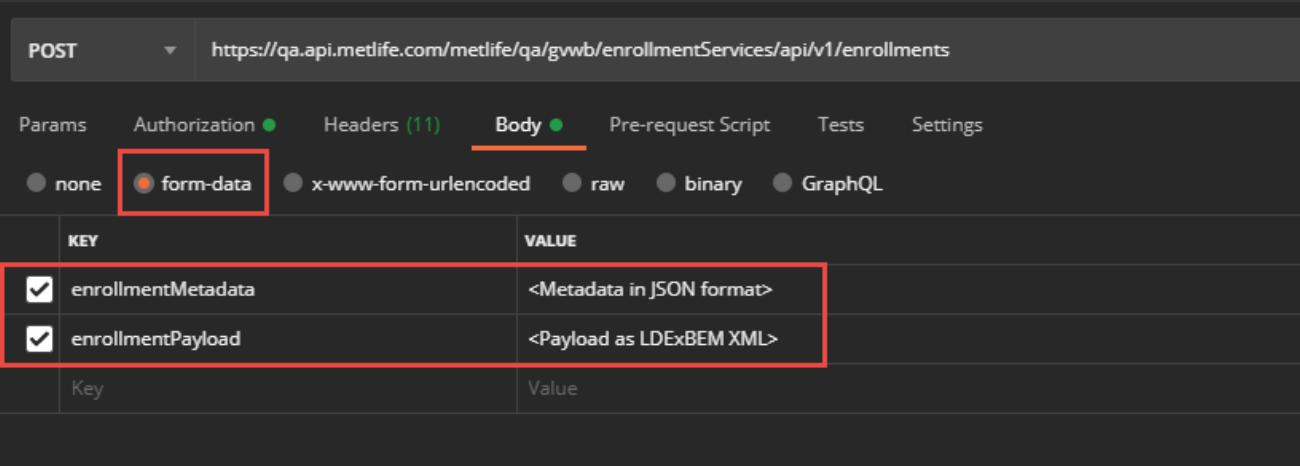


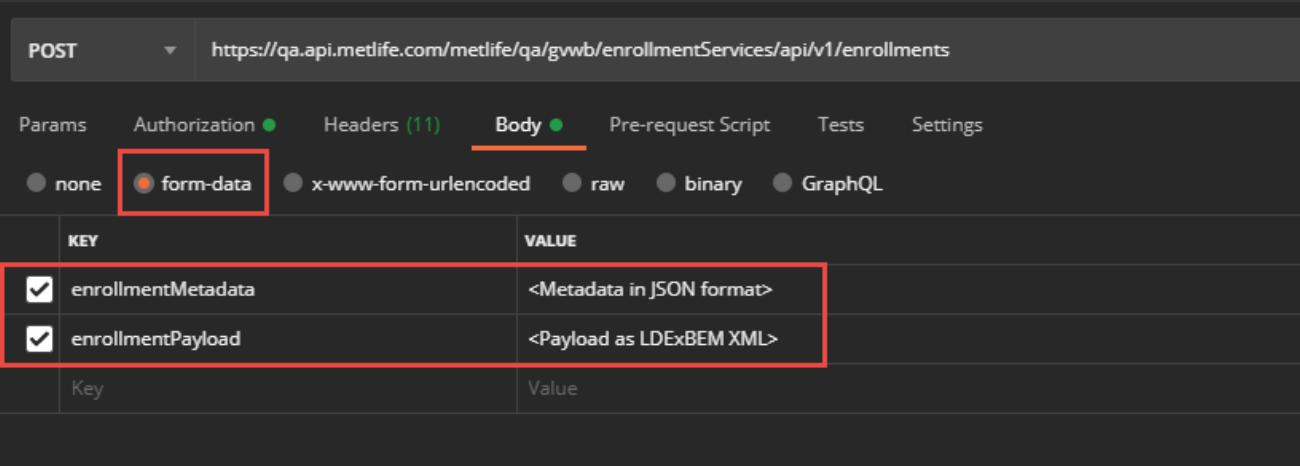

In [19]:
response = chain.invoke("Give me a list of all Enrollment API URLs")
print(response["response"])
for image in response['context']['images']:
    plt_img_base64(response['context']['images'][0])